In [14]:
#https://www.themarketingtechnologist.co/helping-our-new-data-scientists-start-in-python-a-guide-to-learning-by-doing/

In [15]:
#MNGR wants to be able to predict probability of a user having his first engagement
#Predict the engagement conversion probability based on number of pageviews
#Hypothesis: More pageviews lead to a higher probability of engaging for the 1st time

In [71]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt

In [44]:
# Read Session Data
df_sessions = pd.read_excel('/Users/frank.mancuso/Desktop/datasets/df_sessions2.xlsx')
# Read Engagement Data
df_engagements = pd.read_excel('/Users/frank.mancuso/Desktop/datasets/df_engagements2.xlsx')

In [54]:
relevant_columns = ['session_start_date', 'user_id', 'session_number', 'pageviews']
df_sessions = df_sessions[relevant_columns]
df_sessions.columns = ['datetime' if x=='session_start_date' else x for x in df_sessions.columns]
df_sessions.head()

,datetime,user_id,session_number,pageviews
0,2016-09-03 20:08:00,1bd1bd94-9338-41af-89be-7a966f4240b1,1.0,4.0
1,2016-09-05 12:12:31,1bd1bd94-9338-41af-89be-7a966f4240b1,2.0,6.0
2,2016-09-08 17:05:48,1bd1bd94-9338-41af-89be-7a966f4240b1,3.0,4.0
3,2016-09-03 00:12:43,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,1.0,4.0
4,2016-09-04 01:01:26,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,2.0,5.0


In [53]:
relevant_columns = ['engagement_unix_timestamp', 'user_id']
df_engagements = df_engagements[relevant_columns]
df_engagements.columns = ['datetime' if x=='engagement_unix_timestamp' else x for x in df_engagements.columns]
df_engagements.head()

,datetime,user_id
0,2016-09-07 05:24:47,2a50dc0e-36f6-49e2-aa93-43d4b29fa983
1,2016-09-10 21:45:35,0128b0a5-958c-48c0-a5b8-8f0e4107e255
2,2016-09-08 14:23:37,0a67476f-1f1c-4eb6-b154-d20251145f50
3,2016-09-20 19:50:05,0a67476f-1f1c-4eb6-b154-d20251145f50
4,2016-09-02 15:38:54,2b086800-e120-44e7-9be8-7f5c80a38cea


In [55]:
# Get only the first engagement of each user
df_engagements.sort_values(['user_id', 'datetime'], ascending=True, inplace=True)
df_engagements = df_engagements.groupby(['user_id'])['datetime'].first().reset_index()
df_engagements.head()

,user_id,datetime
0,000b401d-0ad3-42c9-b5c2-05a3dfb4337a,2016-09-14 10:21:58
1,000e4479-a527-4f42-b80f-bf267cb4f9aa,2016-09-02 08:34:11
2,00207793-ad1b-4462-929c-e059c8b8ba94,2016-09-16 21:11:34
3,0050389a-6525-464d-ad22-7c46ef5fe427,2016-09-09 23:11:12
4,0065d316-386f-4bda-8bf6-a3abd4a7fe13,2016-09-17 04:14:10


In [56]:
# Merge data sets on user_id
df = pd.merge(df_sessions,
                  df_engagements,
                  on='user_id',
                  how='left',
                  suffixes=('_session', '_first_engagement'))
df.head()

,datetime_session,user_id,session_number,pageviews,datetime_first_engagement
0,2016-09-03 20:08:00,1bd1bd94-9338-41af-89be-7a966f4240b1,1.0,4.0,NaT
1,2016-09-05 12:12:31,1bd1bd94-9338-41af-89be-7a966f4240b1,2.0,6.0,NaT
2,2016-09-08 17:05:48,1bd1bd94-9338-41af-89be-7a966f4240b1,3.0,4.0,NaT
3,2016-09-03 00:12:43,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,1.0,4.0,2016-09-07 05:24:47
4,2016-09-04 01:01:26,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,2.0,5.0,2016-09-07 05:24:47


In [57]:
# Delete sessions that are after the first engagement, not necessary for this analysis.
condition = df['datetime_first_engagement'] >= df['datetime_session']
df = df[condition].copy()
df.head()

,datetime_session,user_id,session_number,pageviews,datetime_first_engagement
3,2016-09-03 00:12:43,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,1.0,4.0,2016-09-07 05:24:47
4,2016-09-04 01:01:26,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,2.0,5.0,2016-09-07 05:24:47
7,2016-09-04 09:09:40,0128b0a5-958c-48c0-a5b8-8f0e4107e255,1.0,5.0,2016-09-10 21:45:35
8,2016-09-07 21:09:50,0128b0a5-958c-48c0-a5b8-8f0e4107e255,2.0,5.0,2016-09-10 21:45:35
9,2016-09-09 07:07:52,0128b0a5-958c-48c0-a5b8-8f0e4107e255,3.0,2.0,2016-09-10 21:45:35


In [63]:

# Add conversion metric
df['is_conversion'] = False
# Get row indices of sessions with engagements and set is_conversion to true
indices = df.groupby(['user_id']).apply(lambda x: x['datetime_session'].idxmax())
df.loc[indices, 'is_conversion'] = True
df.head()

,datetime_session,user_id,session_number,pageviews,datetime_first_engagement,is_conversion
3,2016-09-03 00:12:43,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,1.0,4.0,2016-09-07 05:24:47,False
4,2016-09-04 01:01:26,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,2.0,5.0,2016-09-07 05:24:47,True
7,2016-09-04 09:09:40,0128b0a5-958c-48c0-a5b8-8f0e4107e255,1.0,5.0,2016-09-10 21:45:35,False
8,2016-09-07 21:09:50,0128b0a5-958c-48c0-a5b8-8f0e4107e255,2.0,5.0,2016-09-10 21:45:35,False
9,2016-09-09 07:07:52,0128b0a5-958c-48c0-a5b8-8f0e4107e255,3.0,2.0,2016-09-10 21:45:35,True


In [64]:
# Add cumulative sum of pageviews
df['pageviews_cumsum'] = df.groupby('user_id')['pageviews'].cumsum()
df.head()

,datetime_session,user_id,session_number,pageviews,datetime_first_engagement,is_conversion,pageviews_cumsum
3,2016-09-03 00:12:43,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,1.0,4.0,2016-09-07 05:24:47,False,4.0
4,2016-09-04 01:01:26,2a50dc0e-36f6-49e2-aa93-43d4b29fa983,2.0,5.0,2016-09-07 05:24:47,True,9.0
7,2016-09-04 09:09:40,0128b0a5-958c-48c0-a5b8-8f0e4107e255,1.0,5.0,2016-09-10 21:45:35,False,5.0
8,2016-09-07 21:09:50,0128b0a5-958c-48c0-a5b8-8f0e4107e255,2.0,5.0,2016-09-10 21:45:35,False,10.0
9,2016-09-09 07:07:52,0128b0a5-958c-48c0-a5b8-8f0e4107e255,3.0,2.0,2016-09-10 21:45:35,True,12.0


In [66]:
# Logistic regression
X = df['pageviews_cumsum']
X = sm.add_constant(X)
y = df['is_conversion']
logit = sm.Logit(y, X)
logistic_regression_results = logit.fit()
print(logistic_regression_results.summary())
logistic_regression_results

Optimization terminated successfully.
         Current function value: 0.550797
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          is_conversion   No. Observations:                 6764
Model:                          Logit   Df Residuals:                     6762
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Jan 2020   Pseudo R-squ.:                  0.1594
Time:                        16:27:28   Log-Likelihood:                -3725.6
converged:                       True   LL-Null:                       -4432.2
Covariance Type:            nonrobust   LLR p-value:                2.820e-309
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.2724      0.060    -37.777      0.000      -2.390      -2.154
pageviews_c

C:\Users\frank.mancuso\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [68]:
# Predict the conversion probability for 0 up till 50 pageviews
X = sm.add_constant(range(0, 50))
y_hat = logistic_regression_results.predict(X)
df_hat = pd.DataFrame(zip(X[:, 1], y_hat))
df_hat.columns = ['X', 'y_hat']
p_conversion_25_pageviews = df_hat.loc[25]['y_hat']
print("")
print("The probability of converting after 25 pageviews is {}".format(p_conversion_25_pageviews))


The probability of converting after 25 pageviews is 0.881203420473


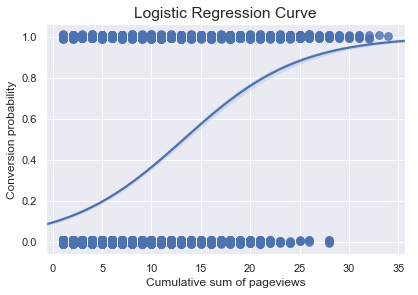

In [73]:
# Visualize logistic curve using seaborn
sns.set(style="darkgrid")
sns.regplot(x="pageviews_cumsum",
                y="is_conversion",
                data=df,
                logistic=True,
                n_boot=500,
                y_jitter=.01,
                scatter_kws={"s": 60})
sns.set(font_scale=1.3)
plt.title('Logistic Regression Curve')
plt.ylabel('Conversion probability')
plt.xlabel('Cumulative sum of pageviews')
plt.subplots_adjust(right=0.93, top=0.90, left=0.10, bottom=0.10)
plt.show()